In [4]:
import os
import pandas as pd
import numpy as np
from pandas_data_download import stock
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, legend, rcParams
import matplotlib

rcParams.update({'font.size': 100})

%matplotlib inline

In [5]:
# Import Banking Data
banking_data = pd.read_excel("Master_Excel.xlsx", "Banking")

In [14]:
#hdfc = stock('HDFCBANK.NS')
#icici = stock('ICICIBANK.NS')

#escorts = stock('ESCORTS.NS', '2015-01-01', '2017-03-10')

bank_nifty = stock('^NSEBANK', '2010-01-01', '2017-03-10')
nifty = stock('^NSEI', '2010-01-01', '2017-03-10')

In [18]:
bank_nifty.data_matrix['input_data'].to_excel('bank_nifty.xlsx')
nifty.data_matrix['input_data'].to_excel('nifty.xlsx')

In [55]:
# Function to plot time series diagonistic
def tsdiag(stockObject, return_type = 'Simple_Returns'):
    
    fig = plt.figure()
    fig.tight_layout
#    fig.set_figwidth(100)
    fig.set_figheight(20)

    ax1 = fig.add_subplot(4, 1, 1)
    ax1.hist(stockObject.data_matrix['returns_data'][return_type])
    ax1_1 = ax1.twinx()
    ax1_1.plot(stockObject.kde_func[return_type]['x_kde'], 
               stockObject.kde_func[return_type]['y_kde'](stockObject.kde_func[return_type]['x_kde']),
               color = 'black', lw = '2')
    ax1.set_ylabel('Frequency')
    ax1_1.set_ylabel('KDE')
    ax1_1.axvline(x = 0, color = 'black', ls = '--')

    ax2 = fig.add_subplot(4, 1, 2)
    ax2.plot(stockObject.acf_pacf[return_type]['acf'], 'b-', lw = 2)
    ax2.plot(stockObject.acf_pacf[return_type]['acf'], 'ro', markersize = 5)
    ax2.axhline(y = 0.05, color = 'black', ls = '--')
    ax2.axhline(y = -0.05, color = 'black', ls = '--')
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('ACF')

    ax3 = fig.add_subplot(4, 1, 3)
    ax3.plot(stockObject.acf_pacf[return_type]['pacf'], 'b-', lw = 2)
    ax3.plot(stockObject.acf_pacf[return_type]['pacf'], 'ro', markersize = 5)
    ax3.axhline(y = 0.05, color = 'black', ls = '--')
    ax3.axhline(y = -0.05, color = 'black', ls = '--')
    ax3.set_xlabel('Lag')
    ax3.set_ylabel('PACF')

    ax4 = fig.add_subplot(4, 1, 4)
    ax4.plot(stockObject.cdf[return_type]['Return'], stockObject.cdf[return_type]['CDF'], 'g-', lw = 2)
    ax4.set_xlabel('Returns')
    ax4.set_ylabel('P')

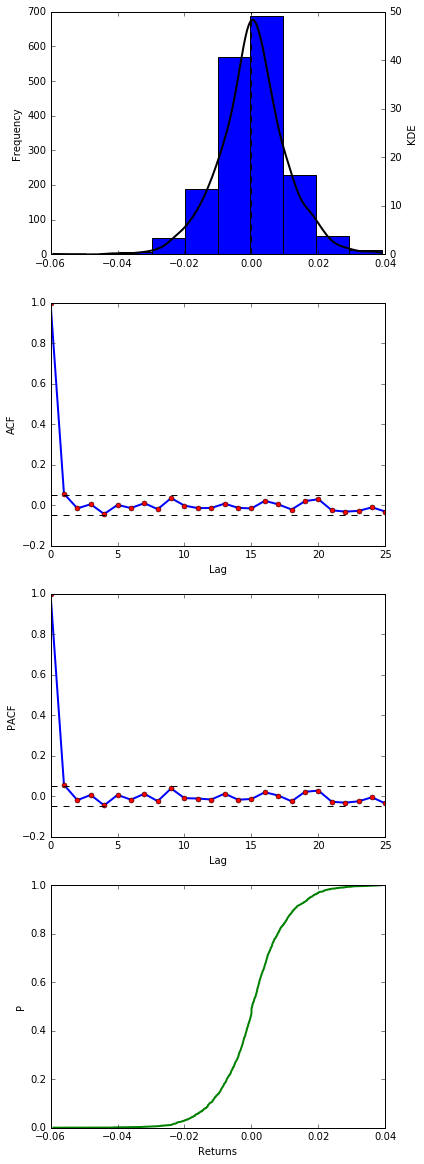

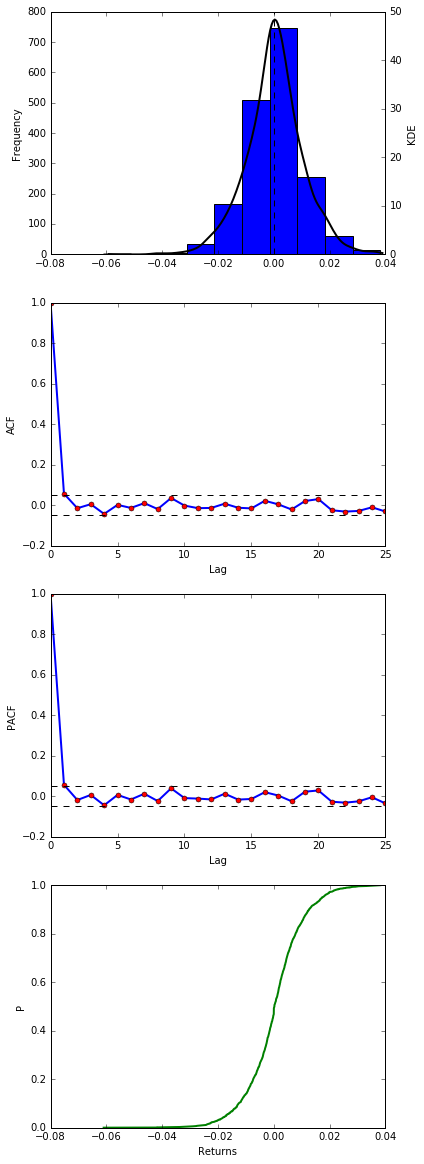

In [56]:
# matplotlib.rcParams.update({'font.size': 40})

# matplotlib.rc('xtick', labelsize=40) 
# matplotlib.rc('ytick', labelsize=40)

tsdiag(nifty, 'Simple_Returns')
tsdiag(nifty, 'Log_Returns')

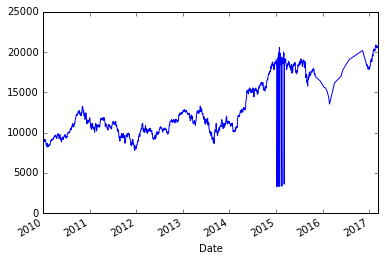

In [11]:
matplotlib.rcParams.update({'font.size': 10})

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

bank_nifty.data_matrix['input_data']['Close'].plot()

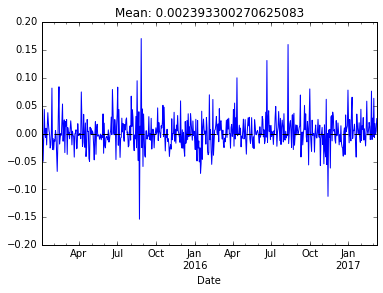

In [120]:
escorts.data_matrix['returns_data']['Log_Returns'].plot()
plt.axhline(y = 0.0, color = 'black', ls = '--')
plt.title("Mean: {}".format(escorts.data_matrix['returns_data']['Log_Returns'].mean()))

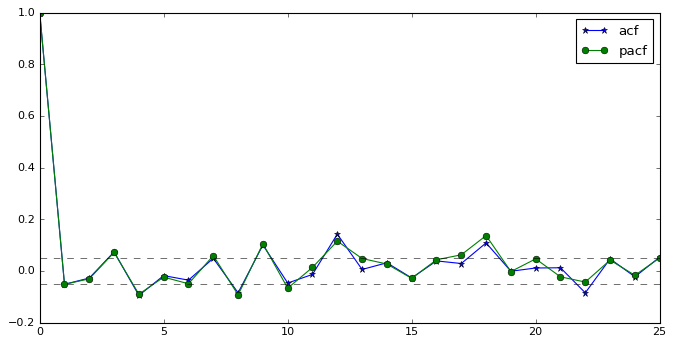

In [122]:
# number of points in acf and pacf
n = len(hdfc.acf_pacf['Log_Returns']['acf'])

# Figure dimensions
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')


plt.plot(hdfc.acf_pacf['Log_Returns']['acf'], marker = '*', label = 'acf')
plt.plot(hdfc.acf_pacf['Log_Returns']['pacf'], marker = 'o', label = 'pacf')
plt.plot([0.05 for x in range(n)], linestyle = '--', color = 'black', linewidth = 0.5)
plt.plot([-0.05 for x in range(n)], linestyle = '--', color = 'black', linewidth = 0.5)

# Display labels as legends
legend()

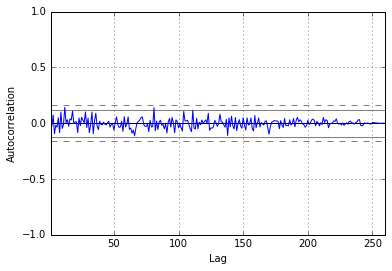

In [123]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(hdfc.data_matrix['returns_data']['Log_Returns'])

In [124]:
from statsmodels.tsa.arima_model import ARIMA

In [125]:
# fit model
model = ARIMA(hdfc.data_matrix['returns_data']['Log_Returns'], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Log_Returns   No. Observations:                  259
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 796.680
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 11 Mar 2017   AIC                          -1587.360
Time:                        20:18:11   BIC                          -1576.689
Sample:                    03-15-2016   HQIC                         -1583.070
                         - 03-10-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.665e-05      0.000      0.036      0.971      -0.001       0.001
ar.L1.D.Log_Returns    -0.5096      0.053     -9.574      0.000      -0.614      -0.405
                

                  0
count  2.590000e+02
mean   5.473510e-07
std    1.118067e-02
min   -3.384530e-02
25%   -7.376783e-03
50%    1.120507e-04
75%    6.771955e-03
max    3.391217e-02


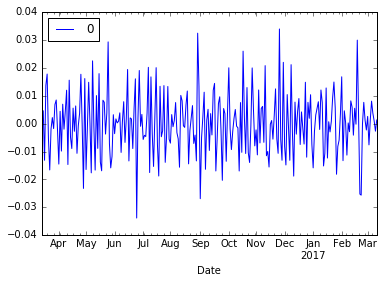

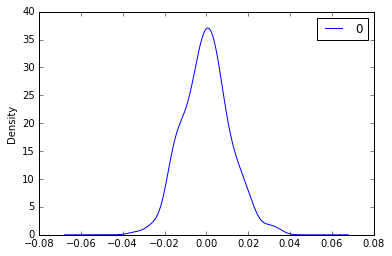

In [126]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())
residuals.plot()
residuals.plot(kind='kde')

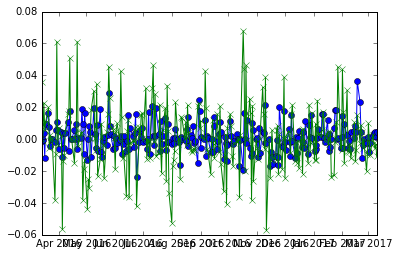

In [128]:
plt.plot(hdfc.data_matrix['returns_data']['Log_Returns'], marker = 'o')
plt.plot(icici.data_matrix['returns_data']['Log_Returns'], marker = 'x')

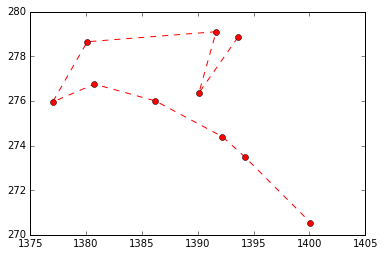

In [130]:
x1 = hdfc.data_matrix['input_data']['Close'][-10:]
x2 = icici.data_matrix['input_data']['Close'][-10:]

plt.plot(x1, x2, marker = 'o', linestyle = '--', color = 'red')

In [21]:
df = pd.merge(left = bank_nifty.data_matrix['returns_data'][['Simple_Returns']].rename(columns = {'Simple_Returns':'bank_nifty'}),
              right = nifty.data_matrix['returns_data'][['Simple_Returns']].rename(columns = {'Simple_Returns':'nifty'}),
              how = 'left',
              right_index = True,
              left_index = True)
              

In [24]:
df1 = df.tail(400)

In [29]:
df1['Lagged_bank_nifty'] = df1.loc[:, ['bank_nifty']].shift(5)

c:\users\kshit\envs\py27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [31]:
df1.head(10)

,bank_nifty,nifty,Lagged_bank_nifty
Date,,,
2014-06-19,-0.010052,-0.002315,NaN
2014-06-20,-0.004629,-0.003879,NaN
2014-06-23,0.005247,-0.002410,NaN
2014-06-24,0.015465,0.011590,NaN
2014-06-25,-0.004680,-0.001445,NaN
2014-06-26,-0.012328,-0.010047,-0.010052
2014-06-27,-0.003831,0.002082,-0.004629
2014-06-30,0.016645,0.013657,0.005247
2014-07-01,0.005213,0.003068,0.015465


In [57]:
corr = []
for i in range(1,300):
    df1['Lagged_bank_nifty'] = df1.loc[:, ['bank_nifty']].shift(i)
    corr_val = df1[['nifty', 'Lagged_bank_nifty']].corr('kendall').iloc[0,1]
    # print("i:{}, corr: {}".format(i, corr_val))
    corr.append(corr_val)

c:\users\kshit\envs\py27\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


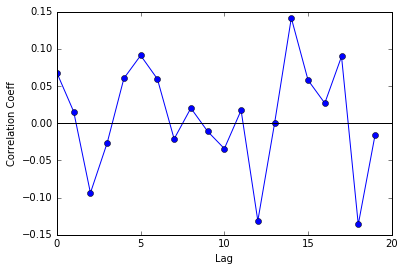

In [62]:
plt.plot(corr[-20:], '-o')
plt.xlabel('Lag')
plt.ylabel('Correlation Coeff')
plt.axhline(y=0.0, color = 'black')

In [59]:
counters = {'>=0':0, '<0':0}
for i in corr:
    if i > 0:
        counters['>=0'] += 1
    else:
        counters['<0'] += 1
print counters

{'<0': 147, '>=0': 152}
